# Regresión Logística

In [148]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
from numpy.random import randn, seed, shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split,cross_validate
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier,export_graphviz, plot_tree
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

In [149]:
columns=["bi_rads", "age", "shape", "margin", "density", "severity"]
datalink = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
df = pd.read_csv(StringIO(requests.get(datalink).text),
                 header=None, na_values="?")
df.columns = columns

train, test = train_test_split(df, test_size=0.2, random_state=314)
train.head()

,bi_rads,age,shape,margin,density,severity
210,4.0,46.0,1.0,1.0,1.0,0
946,4.0,57.0,2.0,4.0,3.0,0
638,4.0,67.0,2.0,1.0,3.0,0
473,4.0,61.0,1.0,1.0,3.0,0
334,4.0,64.0,4.0,4.0,3.0,0


In [150]:
train.columns

Index(['bi_rads', 'age', 'shape', 'margin', 'density', 'severity'], dtype='object')

In [151]:
train = train.query("bi_rads != 55")

In [152]:
xtrain, ytrain = train.drop('severity',axis=1), train.severity

In [153]:
#ytrain=ytrain.reshape(-1,1)
ytrain.shape

(767,)

In [154]:
xtrain.describe()

,bi_rads,age,shape,margin,density
count,765.000000,762.000000,739.000000,727.000000,709.000000
mean,4.290196,55.413386,2.710419,2.797799,2.898449
std,0.726802,14.294480,1.247235,1.571648,0.402479
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000
50%,4.000000,56.000000,3.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000
max,6.000000,93.000000,4.000000,5.000000,4.000000


In [155]:
input_encode = Pipeline([
    ("imputer", SimpleImputer(strategy='constant')),
    ("ohe", OneHotEncoder(categories="auto"))
])

cX = ColumnTransformer([
    ("categoricals", input_encode, ["bi_rads", "shape", "margin","density"]),
    ("continuous", SimpleImputer(strategy="median"), ["age"])
])

logreg = Pipeline([
    ("cX", cX),
    ("model", LogisticRegression(solver="lbfgs", max_iter=500))
])



# HAcemos Gridsearch para encontrar el mejor modelo

In [156]:
#cX.fit_transform(xtrain).toarray()
#logreg.get_params().keys()

In [157]:
paramgrid={
           "model__C":np.arange(0.5,5,.5)
          }

In [158]:
%%time
lreg_clf = GridSearchCV(logreg, paramgrid, cv=10,n_jobs=7)
lreg_clf.fit(xtrain, ytrain)

Wall time: 17.2 s


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cX',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('categoricals',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [159]:
format(lreg_clf.best_score_, "0.2%")

'82.26%'

**Mejores parámetros**

In [160]:
lreg_clf.best_params_

{'model__C': 2.5}

In [161]:
win=lreg_clf.best_estimator_.get_params()["model"]
winner=Pipeline([("cx", cX),('win', win)])

In [162]:
%%time
cv = cross_validate(winner, xtrain, ytrain, cv=10)
print(f"Cross validation score: {cv['test_score'].mean():0.3%}")

Cross validation score: 82.262%
Wall time: 2.04 s


In [163]:
cv['test_score'].mean() + np.array([-1, 1]) * cv['test_score'].std()

array([0.78066912, 0.86458037])

<h2 style="color:crimson">Ejercicio</h2>

Con el modelo final, prueba el accuracy sobre el *test set*:

1. Entrena el modelo usando `logreg.fit(xtrain, ytrain)`
2. Crea `xtest`, `ytest`,
```python
xtest = test[["age", "margin", "shape", "density", "bi_rads"]].values
ytest = test.severity
```
3. Encuentra el resultado final del modelo 

In [164]:
winner.fit(xtrain,ytrain)

Pipeline(memory=None,
         steps=[('cx',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('categoricals',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                            

In [165]:
xtest = test[['bi_rads', 'age', 'shape', 'margin', 'density']]
ytest = test.severity

# Evaluando en test

In [166]:
winner.score(xtest,ytest)

0.8549222797927462

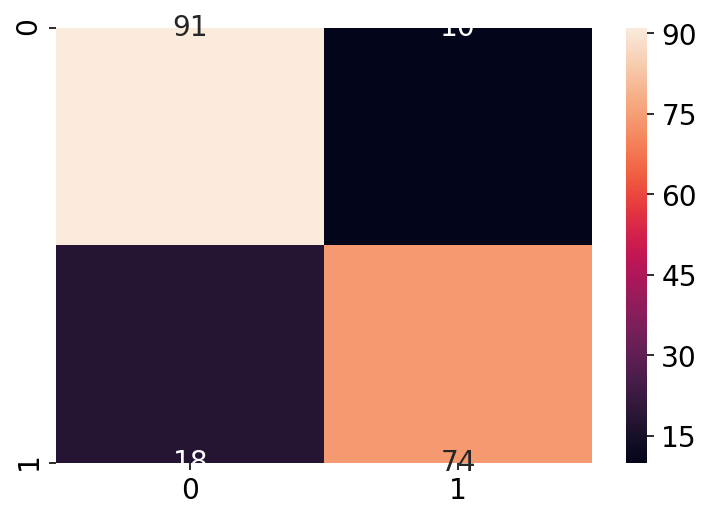

In [167]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

cmat = confusion_matrix(ytest, winner.predict(xtest))
sns.heatmap(cmat, annot=True, fmt=",")

In [168]:
cmat

array([[91, 10],
       [18, 74]], dtype=int64)

$FP=10$

$TP=74$

$TN=91$

$FN=18$

In [169]:
print(classification_report(ytest,winner.predict(xtest)))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       101
           1       0.88      0.80      0.84        92

    accuracy                           0.85       193
   macro avg       0.86      0.85      0.85       193
weighted avg       0.86      0.85      0.85       193



**Precision=.88, recall=.8, accuracy=.86**

In [214]:
#xtest

Text(0.5, 0, 'Age')

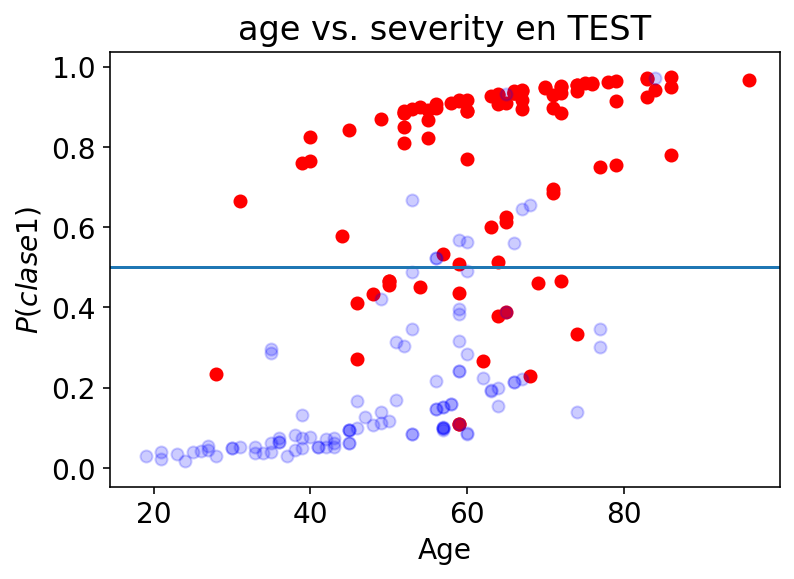

In [244]:
i=1
plt.scatter(xtest[ytest==1].iloc[:,i],winner.predict_proba(xtest)[:,1][ytest==1],color="r")
plt.scatter(xtest[ytest==0].iloc[:,i],winner.predict_proba(xtest)[:,1][ytest==0],color="b",alpha=.2)
#plt.scatter(xtest[winner.predict(xtest)==1].iloc[:,i],winner.predict(xtest)[winner.predict(xtest)==1],color="g",
#            alpha=.4)
#plt.scatter(xtest[winner.predict(xtest)==0].iloc[:,i],winner.predict(xtest)[winner.predict(xtest)==0],color="y",
#            alpha=.4)

plt.title("age vs. severity en TEST")
plt.axhline(y=.5)
plt.ylabel(r"$P(clase 1)$")
plt.xlabel("Age")

Podemos ver que los puntos verdes predicen a los rojos que son los 1's y lo mismo con los azules y amarillos que son los 0´'s.

In [242]:
#winner.predict_proba(xtest)

# Árbol de Decisión

<h2 style="color:crimson">Ejercicio</h2>

1. Entrena y calibra un árbol de decisión para la base de datos `moons`
    * Genera una base de datos usando `make_moons(n_samples=10_000, noise=0.4, random_state=25)` (la función se importa desde `sklearn.datasets`)
    * Divide entre *train* y *test* set usando `train_test_split`
    * Realiza una búsqueda con cross-validation para encontrar hiperparámetros que mejoren un modelo de `DecisionTreeClassifier`. **Comenta tus resultados y lo que encontró el modelo**

In [171]:
lun=make_moons(n_samples=10_000, noise=0.4, random_state=25)
x,y=lun
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=23)

In [172]:
paramtree={"criterion":["gini","entropy"],"max_depth":list(range(2,7)),
           "min_samples_split":list(range(2,10)),"min_samples_leaf":list(range(1,5)),
           "max_features":["sqrt","log2"]
          }
dt=DecisionTreeClassifier()

In [173]:
%%time
dt_clf=GridSearchCV(dt,paramtree,cv=10,n_jobs=7)
dt_clf.fit(x_train,y_train)

Wall time: 16 s


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=7,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [174]:
format(dt_clf.best_score_, "0.2%")

'85.70%'

In [175]:
dt_clf.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 9}

In [176]:
logreg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'cX', 'model', 'cX__n_jobs', 'cX__remainder', 'cX__sparse_threshold', 'cX__transformer_weights', 'cX__transformers', 'cX__verbose', 'cX__categoricals', 'cX__continuous', 'cX__categoricals__memory', 'cX__categoricals__steps', 'cX__categoricals__verbose', 'cX__categoricals__imputer', 'cX__categoricals__ohe', 'cX__categoricals__imputer__add_indicator', 'cX__categoricals__imputer__copy', 'cX__categoricals__imputer__fill_value', 'cX__categoricals__imputer__missing_values', 'cX__categoricals__imputer__strategy', 'cX__categoricals__imputer__verbose', 'cX__categoricals__ohe__categories', 'cX__categoricals__ohe__drop', 'cX__categoricals__ohe__dtype', 'cX__categoricals__ohe__handle_unknown', 'cX__categoricals__ohe__sparse', 'cX__continuous__add_indicator', 'cX__continuous__copy', 'cX__continuous__fill_value', 'cX__continuous__missing_values', 'cX__continuous__strategy', 'cX__continuous__verbose', 'model__C', 'model__class_weight', 'model__dual', 'model__f

**el mejor árbol separa por criterio gini, tiene una profundidad máxima de 6 el número de features con los que prueba es $\sqrt(2)$ ya que 2 es el número de features, el mínimo de observaciones o datos que debe haber en cada nodo es 4 y para poder hacer una partición por lo menos debe haber 7 elementos**

In [177]:
wintree=dt_clf.best_estimator_
#winner=Pipeline([("cx", cX),('win', win)])

In [178]:
wintree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [179]:
%%time
cvt=cross_validate(wintree,x_train,y_train,cv=10)
print(f"Cross validation score: {cvt['test_score'].mean():0.3%}")

Cross validation score: 84.062%
Wall time: 114 ms


In [180]:
cvt['test_score'].mean() + np.array([-1, 1]) * cvt['test_score'].std()

array([0.80547688, 0.87577312])

# Resultados Test

In [181]:
wintree.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [182]:
wintree.score(x_test,y_test)

0.8575

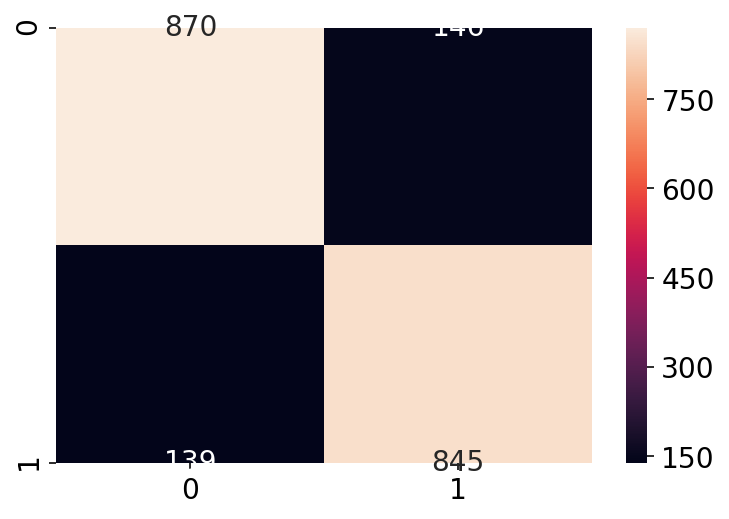

In [183]:
cmat = confusion_matrix(y_test, wintree.predict(x_test))
sns.heatmap(cmat, annot=True, fmt=",")

In [184]:
cmat

array([[870, 146],
       [139, 845]], dtype=int64)

$FP=146$

$TP=845$

$TN=870$

$FN=139$

In [185]:
print(classification_report(y_test,wintree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1016
           1       0.85      0.86      0.86       984

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



**Precision clase 1=.85, Recall clase1: .86, accuracy=.86**

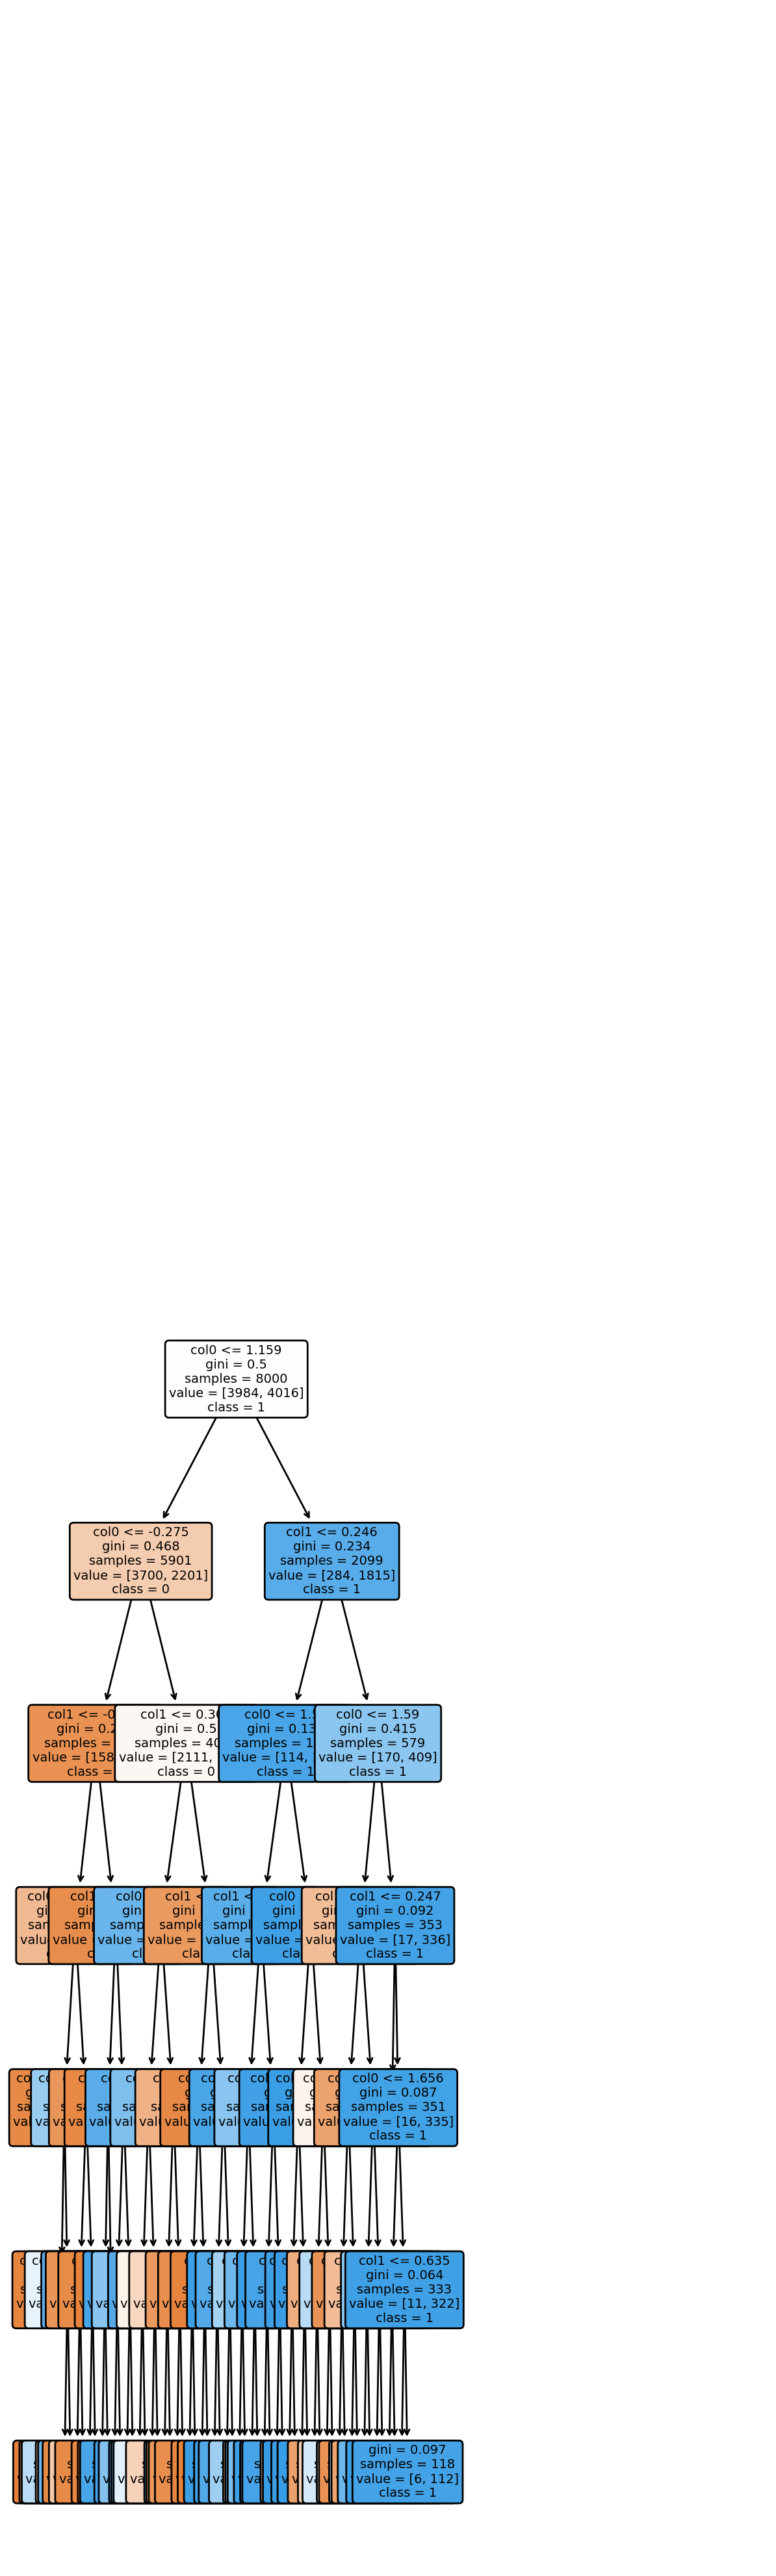

In [190]:
plt.figure(dpi=100, figsize=(7, 26))
plot_tree(wintree,
          feature_names=["col0","col1"],
          class_names=["0", "1"],
         rounded=True,
         filled=True,
         fontsize=7);

Text(0.5, 0, 'Columna 0')

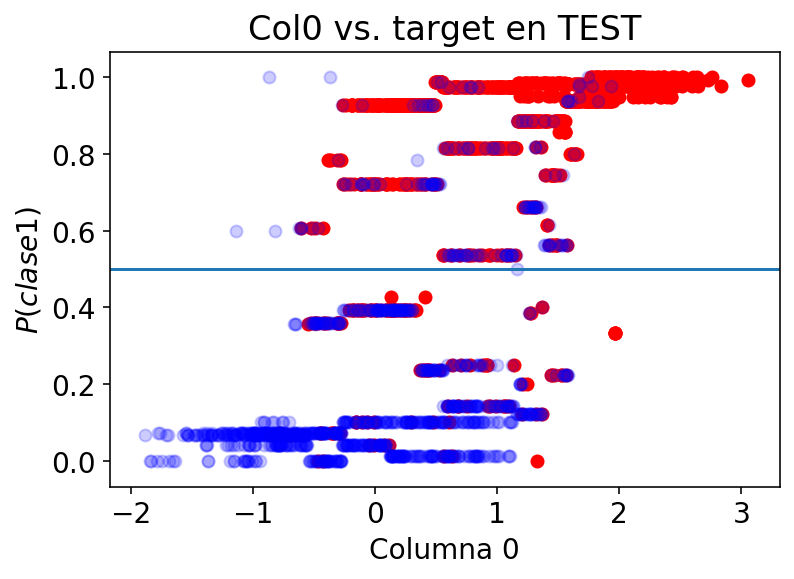

In [235]:
i=0
plt.scatter(x_test[y_test==1][:,i],wintree.predict_proba(x_test)[:,1][y_test==1],color="r")
plt.scatter(x_test[y_test==0][:,i],wintree.predict_proba(x_test)[:,1][y_test==0],color="b", alpha=.2)
#plt.scatter(x_test[wintree.predict(x_test)==1][:,i],wintree.predict_proba(x_test)[:,1][wintree.predict(x_test)==1],color="g",
#            alpha=.2)
#plt.scatter(x_test[wintree.predict(x_test)==0][:,i],wintree.predict_proba(x_test)[:,1][wintree.predict(x_test)==0],color="y",
#            alpha=.9)
plt.axhline(y=.5)
plt.title("Col0 vs. target en TEST")
plt.ylabel(r"$P(clase 1)$")
plt.xlabel("Columna 0")

**Tomando 0.5 como punto de corte podemos ver gráficamente los puntos rojos(1's) por debajo del corte y los azules (0's) por encima de este que representan los errores dado el score que se le dio a cad punto de pertenecer a la clase 1**

In [224]:
wintree.predict_proba(x_test)[:,1]

array([0.92751236, 0.3923445 , 0.07291667, ..., 0.10019646, 0.04109589,
       0.04109589])